<a href="https://colab.research.google.com/github/WellFan/bayesian_with_merchants/blob/main/merchants_goods_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy import stats
import stan
import arviz as az
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
nmerchants = 100
ngoods = np.random.randint(low=1, high=101, size=nmerchants)
alpha_u = 2
beta_u = 98
mu_i = stats.beta.rvs(alpha_u, beta_u, size=nmerchants)
trial = 10*stats.expon.rvs(scale=10, size=nmerchants)
data = np.array(([0], [0], [0], [0]))
for i in range(nmerchants):
  ctr = np.array(stats.beta.rvs(mu_i[i]*trial[i], (1-mu_i[i])*trial[i], size=ngoods[i]))
  impression = np.random.randint(low=1, high=101, size=ngoods[i])
  click = np.array(stats.binom.rvs(impression, ctr))
  merchants_id = np.array([i]*ngoods[i])
  temp = (np.vstack((merchants_id, ctr, impression, click)))
  data = np.hstack((data, temp))
data = np.transpose(data)
data = np.delete(data, 0, 0)

In [3]:
data = np.delete(data, 0, 0)
data.shape

(5468, 4)

In [4]:
text='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  vector<lower=0>[M] trial;
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu.*trial;
  beta_i = (1-mu).*trial;
}
model{
  alpha_u~uniform(0.01, 100);
  beta_u~uniform(0.01, 100);
  mu~beta(alpha_u, beta_u);
  trial~gamma(10, 10);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df = fit.to_frame()

Building...



Building: 60.5s, done.Messages from stanc:
Warning in '/tmp/httpstan_rwoo4hex/model_qleo6ac4.stan', line 23, column 23: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_rwoo4hex/model_qleo6ac4.stan', line 23, column 17: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_rwoo4hex/model_qleo6ac4.stan', line 23, column 2: Parameter beta_u is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; 

In [5]:
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-25743.837617,0.866215,0.175467,5.0,31.0,0.0,25855.678192,0.114807,0.088565,0.167462,...,1.767098,1.512124,1.010023,1.410375,1.854979,1.767778,1.037661,1.925236,1.965585,1.201127
1,-25746.761409,0.914434,0.175467,5.0,31.0,0.0,25840.839239,0.132404,0.080379,0.105607,...,1.825297,2.079362,1.735219,0.477383,2.447318,2.007740,1.244381,2.057485,3.259200,0.969116
2,-25752.381868,0.831730,0.175467,5.0,31.0,0.0,25851.166220,0.152703,0.074535,0.103980,...,1.563298,1.887060,1.825470,0.459004,2.010230,2.124137,1.056474,1.937123,2.682254,1.151873
3,-25752.355904,0.981185,0.175467,5.0,31.0,0.0,25835.590187,0.121133,0.085167,0.146646,...,2.204517,1.500475,1.163502,1.537926,2.069866,1.554050,0.960223,2.273356,1.764731,0.808081
4,-25759.176095,0.968171,0.175467,5.0,31.0,0.0,25847.085046,0.124701,0.101377,0.072199,...,1.207089,2.302574,0.836811,0.618930,2.176079,2.421306,1.493874,2.343131,3.387660,1.043641


In [6]:
df.iloc[:,107:207].mean()

parameters
trial.1      1.850110
trial.2      2.038355
trial.3      1.950830
trial.4      1.504335
trial.5      0.927885
               ...   
trial.96     1.855049
trial.97     1.251313
trial.98     2.326617
trial.99     2.595091
trial.100    1.042491
Length: 100, dtype: float64

In [7]:
alpha_u = df['alpha_u']
beta_u = df['beta_u']
mu = df.iloc[:,7:107]
trial = df.iloc[:,107:207]
alpha_i = df.iloc[:, 209:309]
beta_i = df.iloc[:, 309:409]

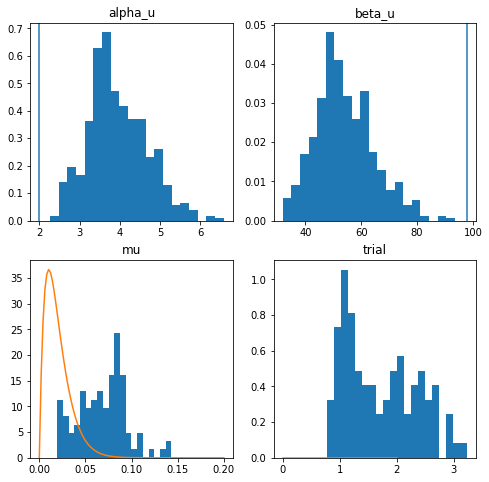

In [8]:
points = np.linspace(0, 100, 1001, endpoint=True)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes[0,0].set_title('alpha_u')
axes[0,0].hist(alpha_u, density=True, bins=20)
axes[0,0].axvline(2)
axes[0,1].set_title('beta_u')
axes[0,1].hist(beta_u, density=True, bins=20)
axes[0,1].axvline(98)
axes[1,0].set_title('mu')
axes[1,0].hist(mu.mean(), density=True, bins=20)
axes[1,0].plot(np.linspace(0, 0.2, 100), stats.beta.pdf(np.linspace(0, 0.2, 100), 2, 98))
axes[1,1].set_title('trial')
axes[1,1].hist(trial.mean(), density=True, bins=20)
axes[1,1].plot(np.linspace(0, 2, 100), stats.gamma.pdf(np.linspace(0, 2, 100), 10, 10))

In [9]:
customer_stan = pd.DataFrame(data, columns=['merchant_id', 'ctr', 'impression', 'click'])
customer_stan = customer_stan.astype({'merchant_id':int, 'impression':int, 'click':int})
customer_stan.head()

,merchant_id,ctr,impression,click
0,0,0.030642,31,3
1,0,0.051895,10,0
2,0,0.086208,93,4
3,0,0.038929,67,4
4,0,0.072532,52,4


In [10]:
customer_stan['alpha_i'] = alpha_i.mean()[customer_stan.merchant_id][1]
customer_stan['beta_i'] = beta_i.mean()[customer_stan.merchant_id][1]
customer_stan = customer_stan.assign(avg_stan = lambda df:(df.click+df.alpha_i)/(df.impression+df.alpha_i+df.beta_i))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan
0,0,0.030642,31,3,0.253067,1.597043,0.099028
1,0,0.051895,10,0,0.253067,1.597043,0.021356
2,0,0.086208,93,4,0.253067,1.597043,0.044840
3,0,0.038929,67,4,0.253067,1.597043,0.061773
4,0,0.072532,52,4,0.253067,1.597043,0.078980


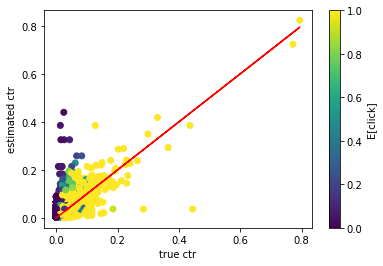

In [11]:
plt.scatter(customer_stan.ctr, customer_stan.avg_stan, c=customer_stan.impression*customer_stan.ctr, cmap='viridis', vmin=0, vmax=1)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.xlabel('true ctr')
plt.ylabel('estimated ctr')
plt.colorbar(label='E[click]')
plt.show()

In [12]:
customer_stan.ctr.corr(customer_stan.avg_stan)

0.7094617579166091

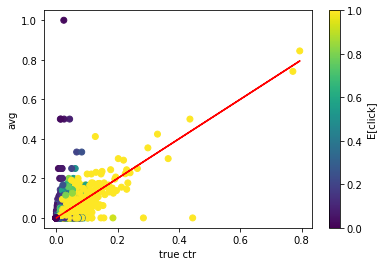

In [13]:
plt.scatter(customer_stan.ctr, customer_stan.click/customer_stan.impression, c=customer_stan.impression*customer_stan.ctr, cmap='viridis', vmin=0, vmax=1)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.xlabel('true ctr')
plt.ylabel('avg')
plt.colorbar(label='E[click]')
plt.show()

In [39]:
text2='''
data{
  int<lower=0> N;
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  real<lower=0> alpha;
  real<lower=0> beta;
}
model{
  alpha~uniform(0.01, 100);
  beta~uniform(0.01, 100);
  click~beta_binomial(impression, alpha, beta);
}
'''
stan_data = {'N':data.shape[0], 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text2, data=stan_data)
fit = posterior.sample(num_chains=2, num_samples=500)
df_nomerchant = fit.to_frame()

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_owi749rr/model_ljmo6j7a.stan', line 13, column 21: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_owi749rr/model_ljmo6j7a.stan', line 13, column 15: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_owi749rr/model_ljmo6j7a.stan', line 13, column 2: Parameter beta is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constr

In [40]:
df_nomerchant.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta
draws,,,,,,,,,
0,-23697.210349,0.996671,0.336415,4.0,15.0,0.0,23697.610297,0.482210,25.336277
1,-23695.710714,0.876886,0.426882,3.0,11.0,0.0,23698.004942,0.552204,28.371931
2,-23695.854680,0.874351,0.336415,3.0,7.0,0.0,23698.389131,0.519033,26.484624
3,-23694.700058,0.985552,0.426882,2.0,5.0,0.0,23695.926623,0.548210,29.639864
4,-23695.098986,0.983968,0.336415,2.0,7.0,0.0,23697.447358,0.533336,29.336238


In [46]:
alpha_true = df_nomerchant.alpha.mean()
beta_true = df_nomerchant.beta.mean()
customer_stan = customer_stan.assign(avg_bayesian = lambda df:(df.click+alpha_true)/(df.impression+alpha_true+beta_true))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,avg_bayesian,alpha_proun,beta_proun,avg_uni_trial
0,0,0.030642,31,3,0.253067,1.597043,0.099028,0.059028,1.266125,17.677694,0.085418
1,0,0.051895,10,0,0.253067,1.597043,0.021356,0.013696,1.266125,17.677694,0.043744
2,0,0.086208,93,4,0.253067,1.597043,0.044840,0.037197,1.266125,17.677694,0.047043
3,0,0.038929,67,4,0.253067,1.597043,0.061773,0.047289,1.266125,17.677694,0.061274
4,0,0.072532,52,4,0.253067,1.597043,0.078980,0.056064,1.266125,17.677694,0.074230


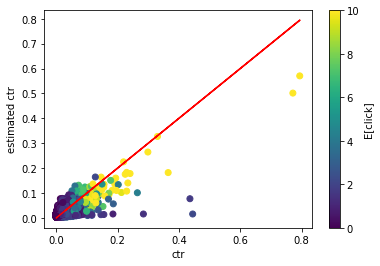

In [44]:
plt.scatter(customer_stan.ctr, customer_stan.avg_bayesian, c=customer_stan.impression*customer_stan.ctr, cmap='viridis', vmin=0, vmax=10)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.colorbar(label='E[click]')
plt.xlabel('ctr')
plt.ylabel('estimated ctr')
plt.show()

In [18]:
text3='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  real<lower=0> trial;
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu*trial;
  beta_i = (1-mu)*trial;
}
model{
  alpha_u~uniform(0.01, 100);
  beta_u~uniform(0.01, 100);
  mu~beta(alpha_u, beta_u);
  trial~gamma(10, 10);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text3, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df_same_trial = fit.to_frame()

Building...



Building: 44.3s, done.Messages from stanc:
Warning in '/tmp/httpstan_cippv56v/model_jrtab5sx.stan', line 23, column 23: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_cippv56v/model_jrtab5sx.stan', line 23, column 17: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_cippv56v/model_jrtab5sx.stan', line 23, column 2: Parameter beta_u is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; 

In [19]:
df_same_trial.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-23649.806729,0.917235,0.073989,3.0,13.0,1.0,23701.592628,0.046462,0.026324,0.059648,...,19.331110,19.325229,19.589400,19.593444,19.407871,19.496421,19.572867,19.252860,19.178623,19.357650
1,-23655.170914,0.944961,0.073989,4.0,20.0,1.0,23703.535129,0.053319,0.028952,0.054438,...,19.760103,19.893469,20.167036,20.172279,19.987566,20.082585,20.139416,19.852040,19.632257,20.045775
2,-23652.839220,0.940785,0.073989,4.0,22.0,1.0,23710.854020,0.049884,0.022339,0.063661,...,19.496614,19.488177,19.809298,19.813919,19.630946,19.719356,19.796137,19.474621,19.227092,19.740803
3,-23656.561879,0.943469,0.073989,4.0,18.0,1.0,23720.842057,0.047928,0.025481,0.059152,...,18.981410,18.975884,19.340323,19.346262,19.216681,19.224511,19.295127,19.043728,18.786494,19.157086
4,-23660.051362,0.949500,0.073989,4.0,20.0,1.0,23702.326881,0.055256,0.027236,0.061816,...,19.056173,19.015672,19.368255,19.376548,19.265428,19.202683,19.352758,19.064672,18.763201,19.213927


In [20]:
mu2 = df_same_trial.iloc[:,7:107].mean()
alpha_proun = df_same_trial.iloc[:,107].mean()*mu2
beta_proun = df_same_trial.iloc[:,107].mean()-alpha_proun

In [21]:
customer_stan['alpha_proun'] = alpha_proun[customer_stan.merchant_id][1]
customer_stan['beta_proun'] = beta_proun[customer_stan.merchant_id][1]
customer_stan = customer_stan.assign(avg_uni_trial = lambda df:(df.click+df.alpha_proun)/(df.impression+df.alpha_proun+df.beta_proun))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,avg_bayesian,alpha_proun,beta_proun,avg_uni_trial
0,0,0.030642,31,3,0.253067,1.597043,0.099028,0.059105,1.266125,17.677694,0.085418
1,0,0.051895,10,0,0.253067,1.597043,0.021356,0.013683,1.266125,17.677694,0.043744
2,0,0.086208,93,4,0.253067,1.597043,0.044840,0.037215,1.266125,17.677694,0.047043
3,0,0.038929,67,4,0.253067,1.597043,0.061773,0.047323,1.266125,17.677694,0.061274
4,0,0.072532,52,4,0.253067,1.597043,0.078980,0.056117,1.266125,17.677694,0.074230


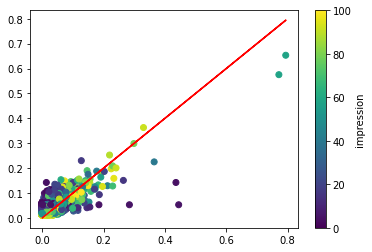

In [22]:
plt.scatter(customer_stan.ctr, customer_stan.avg_uni_trial, c=customer_stan.impression, cmap='viridis', vmin=0, vmax=100)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.colorbar(label='impression')
plt.show()

In [28]:
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,avg_bayesian,alpha_proun,beta_proun,avg_uni_trial
0,0,0.030642,31,3,0.253067,1.597043,0.099028,0.059105,1.266125,17.677694,0.085418
1,0,0.051895,10,0,0.253067,1.597043,0.021356,0.013683,1.266125,17.677694,0.043744
2,0,0.086208,93,4,0.253067,1.597043,0.044840,0.037215,1.266125,17.677694,0.047043
3,0,0.038929,67,4,0.253067,1.597043,0.061773,0.047323,1.266125,17.677694,0.061274
4,0,0.072532,52,4,0.253067,1.597043,0.078980,0.056117,1.266125,17.677694,0.074230


In [38]:
# the mse of same trial same merchants is estimated by one chain
print(
'different merchants and different trial', ((customer_stan.ctr-customer_stan.avg_stan)**2).mean(),'\n',
'same merchants and same trial', ((customer_stan.ctr-customer_stan.avg_bayesian)**2).mean(),'\n',
'different merchants and same trial', ((customer_stan.ctr-customer_stan.avg_uni_trial)**2).mean())

different merchants and different trial 0.0007803389266075426 
 same merchants and same trial 0.0003526342012484803 
 different merchants and same trial 0.0007105449590662234


In [47]:
# the mse of same trial same merchants is estimated by two chain
print(
'different merchants and different trial', ((customer_stan.ctr-customer_stan.avg_stan)**2).mean(),'\n',
'same merchants and same trial', ((customer_stan.ctr-customer_stan.avg_bayesian)**2).mean(),'\n',
'different merchants and same trial', ((customer_stan.ctr-customer_stan.avg_uni_trial)**2).mean())

different merchants and different trial 0.0007803389266075426 
 same merchants and same trial 0.00035277293824324547 
 different merchants and same trial 0.0007105449590662234
